<a href="https://colab.research.google.com/github/sayakpaul/SimSiam-TF/blob/main/SimSiam_Pre_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A minimal implementation of **SimSiam** as proposed in [Exploring Simple Siamese Representation Learning](https://arxiv.org/pdf/2011.10566.pdf) by Xinlei Chen and Kaiming He. The objective of this notebook is to demonstrate the workflow of SimSiam and NOT to implement it note to note and at the same time I will try not to miss out on the major bits discussed in the paper. For that matter, I'll be using the Flowers dataset. 

Following depicts the workflow of SimSiam - 

<center>
<img src="https://i.ibb.co/37pNQTP/image.png" width=550></img>
</center>

In [1]:
#!pip install -U -q tensorflow-addons

In [2]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

from tqdm import tqdm

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [4]:
!nvidia-smi

Tue Dec  7 23:21:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:01:00.0  On |                  N/A |
| 10%   55C    P0    40W / 180W |    438MiB /  8111MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "mnist",
    split=['train', 'test']
)

2021-12-07 23:21:03.466421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 23:21:03.511789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 23:21:03.512241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 23:21:03.513722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
print( type(train_ds), type(validation_ds) )
print(len(train_ds), len(validation_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
60000 10000


2021-12-07 23:21:04.475490: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


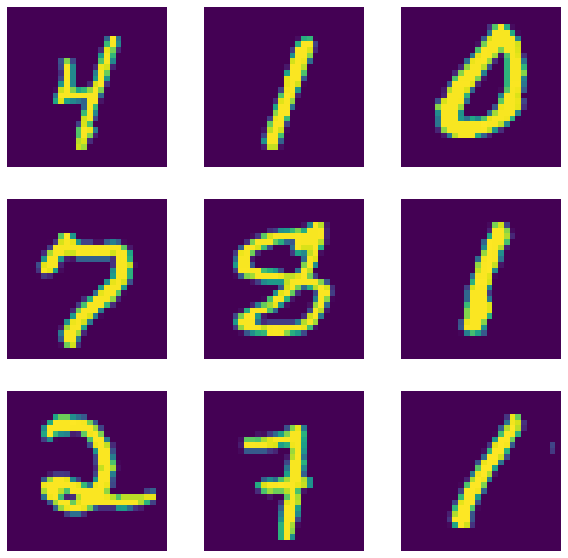

In [7]:
# Visualization
plt.figure(figsize=(10, 10))
for i, image  in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image['image'])
    plt.axis("off")

Note the augmentation pipeline is a bit different from the augmentations followed in the paper. 

In [8]:
# Reference: https://github.com/google-research/simclr/blob/master/data_util.py

@tf.function
def translate(image):
    (h, w) = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.random_flip_left_right(image)

    f = tf.random.uniform([], minval=0, maxval=0.125, dtype=tf.float32)
    (dh, dw) = tf.cast(tf.cast(h, tf.float32)*f, tf.float32), \
        tf.cast(tf.cast(w, tf.float32)*f, tf.float32)
    
    image = tfa.image.translate(image, translations=[dh, dw])
    return image

@tf.function
def gaussian_blur(image, kernel_size=23, padding='SAME'):
    sigma = tf.random.uniform((1,))* 1.9 + 0.1

    radius = tf.cast(kernel_size / 2, tf.int32)
    kernel_size = radius * 2 + 1
    x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
    blur_filter = tf.exp(
        -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
    blur_filter /= tf.reduce_sum(blur_filter)
    # One vertical and one horizontal filter.
    blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
    blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
    num_channels = tf.shape(image)[-1]
    blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
    blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
    expand_batch_dim = image.shape.ndims == 3
    if expand_batch_dim:
        image = tf.expand_dims(image, axis=0)
    blurred = tf.nn.depthwise_conv2d(
        image, blur_h, strides=[1, 1, 1, 1], padding=padding)
    blurred = tf.nn.depthwise_conv2d(
        blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
    if expand_batch_dim:
        blurred = tf.squeeze(blurred, axis=0)
    return blurred

@tf.function
def color_jitter(x, s=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def custom_augment(image):
    image = image['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.image.grayscale_to_rgb(image)

    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    # Random translations
    image = random_apply(translate, image, p=0.5)
    # Randomly apply gausian blur
    image = random_apply(gaussian_blur, image, p=0.5)
    # Randomly apply transformation (color distortions) 
    image = random_apply(color_jitter, image, p=0.8)
    # Randomly apply grayscale
    image = random_apply(color_drop, image, p=0.2)
    
    return image

In [9]:
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

dataset_one = (
    train_ds
    .shuffle(1024, seed=0)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

dataset_two = (
    train_ds
    .shuffle(1024, seed=0)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2021-12-07 23:21:05.778062: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<class 'tensorflow.python.framework.ops.EagerTensor'>


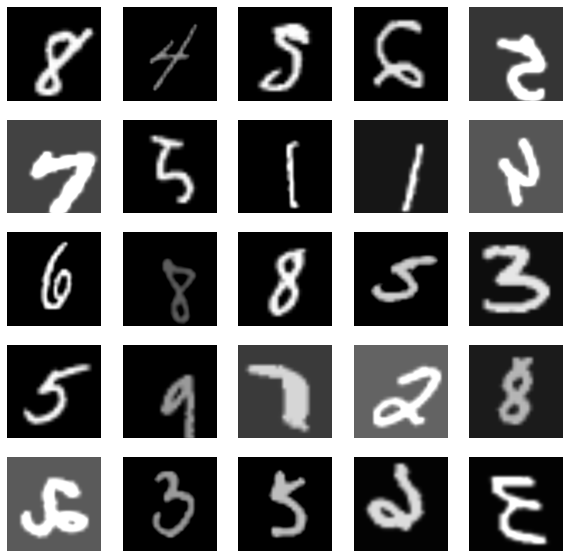

In [10]:
sample_images = next(iter(dataset_one))

print(type(sample_images[0]))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(sample_images[n])
    plt.axis('off')
plt.show()

The network architectures are based on the **Method (Baseline settings)** section of the paper. 

## Encoder ($f$)

This includes ResNet50 as a backbone and another MLP for projection. Note that I have reduced the architectures here leaving ResNet50 backbone intact. 

In [11]:
def get_encoder():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f

## Predictor ($h$)

This includes an MLP. 

In [12]:
def get_predictor():
    inputs = tf.keras.layers.Input((2048, ))
    x = tf.keras.layers.Dense(512, activation='relu', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    p = tf.keras.layers.Dense(2048)(x)

    h = tf.keras.Model(inputs, p)

    return h

In [13]:
get_encoder().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              4194304   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2048)              419635

In [14]:
get_predictor().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_2 (Dense)             (None, 512)               1048576   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 2048)              1050624   
                                                                 
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


The authors have also provided PyTorch-like psuedocode in the paper (how cool!) - 

```python
# f: backbone + projection mlp
# h: prediction mlp
for x in loader: # load a minibatch x with n samples
    x1, x2 = aug(x), aug(x) # random augmentation
    z1, z2 = f(x1), f(x2) # projections, n-by-d
    p1, p2 = h(z1), h(z2) # predictions, n-by-d
    L = D(p1, z2)/2 + D(p2, z1)/2 # loss
    L.backward() # back-propagate
    update(f, h) # SGD update

def D(p, z): # negative cosine similarity
    z = z.detach() # stop gradient
    p = normalize(p, dim=1) # l2-normalize
    z = normalize(z, dim=1) # l2-normalize
    return -(p*z).sum(dim=1).mean()
```

In [15]:
def loss_func(p, z):
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return - tf.reduce_mean(tf.reduce_sum((p*z), axis=1))

In [16]:
@tf.function
def train_step(ds_one, ds_two, f, h, optimizer):
    with tf.GradientTape() as tape:
        z1, z2 = f(ds_one), f(ds_two)
        p1, p2 = h(z1), h(z2)
        loss = loss_func(p1, z2)/2 + loss_func(p2, z1)/2
    
    learnable_params = f.trainable_variables + h.trainable_variables
    gradients = tape.gradient(loss, learnable_params)
    optimizer.apply_gradients(zip(gradients, learnable_params))

    return loss

In [17]:
def train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for ds_one, ds_two in zip(dataset_one, dataset_two):
            loss = train_step(ds_one, ds_two, f, h, optimizer)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))
        f.save_weights("projection_{:03}.h5".format(epoch))
        h.save_weights("prediction_{:03}.h5".format(epoch))

    return epoch_wise_loss, f, h

In [18]:
decay_steps = 500
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.01, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)

f = get_encoder()
h = get_predictor()

epoch_wise_loss, f, h  = train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]2021-12-07 23:21:15.251083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2021-12-07 23:21:15.868463: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-07 23:21:15.869165: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-07 23:21:15.869191: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2021-12-07 23:21:15.869956: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-07 23:21:15.870032: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-07 23:21:16.43130

epoch: 1 loss: -0.964


 20%|██        | 10/50 [2:55:34<11:36:33, 1044.83s/it]

epoch: 11 loss: -0.980


 40%|████      | 20/50 [5:49:28<8:41:45, 1043.52s/it]

epoch: 21 loss: -0.981


 60%|██████    | 30/50 [8:43:22<5:47:49, 1043.47s/it]

epoch: 31 loss: -0.981


 80%|████████  | 40/50 [11:38:37<2:56:03, 1056.30s/it]

epoch: 41 loss: -0.981


100%|██████████| 50/50 [14:33:04<00:00, 1047.68s/it]


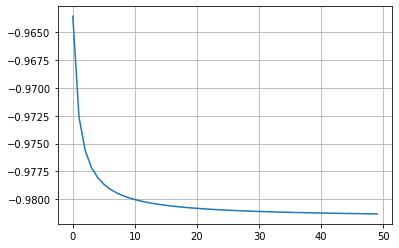

In [19]:
plt.plot(epoch_wise_loss)
plt.grid()
plt.show()

In [20]:
f.save_weights("projection.h5")
h.save_weights("prediction.h5")